In [1]:
%load_ext autoreload
%autoreload 2
# import os
# os.environ['CUDA_VISIBLE_DEVICES']='2'

In [2]:
cd /gitprojects/YOLOX/

/gitprojects/YOLOX


In [3]:
from tools.train import *
import mmcv
print('Num of devices:', torch.cuda.device_count())

Num of devices: 4


# Hyps

In [4]:
# %run tools/train.py -f exps/default/nano.py -d 1 -b 2 --fp16 -o

In [5]:
parser = make_parser()
args = mmcv.Config(parser.parse_known_args()[0].__dict__)

args.exp_file = './exps/default/nano.py'
args.name = 'nano-overfit'
args.devices = 1
args.batch_size = 4
args.occupy = True

# Model

In [6]:
exp = get_exp(args.exp_file, args.name)
exp.merge(args.opts)


In [7]:
# exp

In [8]:
device = 'cuda'
model = exp.get_model()
model.to(device);
optimizer = exp.get_optimizer(args.batch_size)

from apex import amp
model, optimizer = amp.initialize(model, optimizer, opt_level="O1")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


# Loader 

In [64]:
INPUT_SIZE = (640, 640)

In [77]:
from yolox.data import RotatedCOCODataset, TrainTransform
dataset = RotatedCOCODataset(
        data_dir='/data/compressed_ford_demo/',
        json_file='train.json',
        name='image',
        img_size=INPUT_SIZE,
        preproc=TrainTransform(
            rgb_means=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
            max_labels=50,
        ),
    )



loading annotations into memory...
Done (t=0.66s)
creating index...
index created!


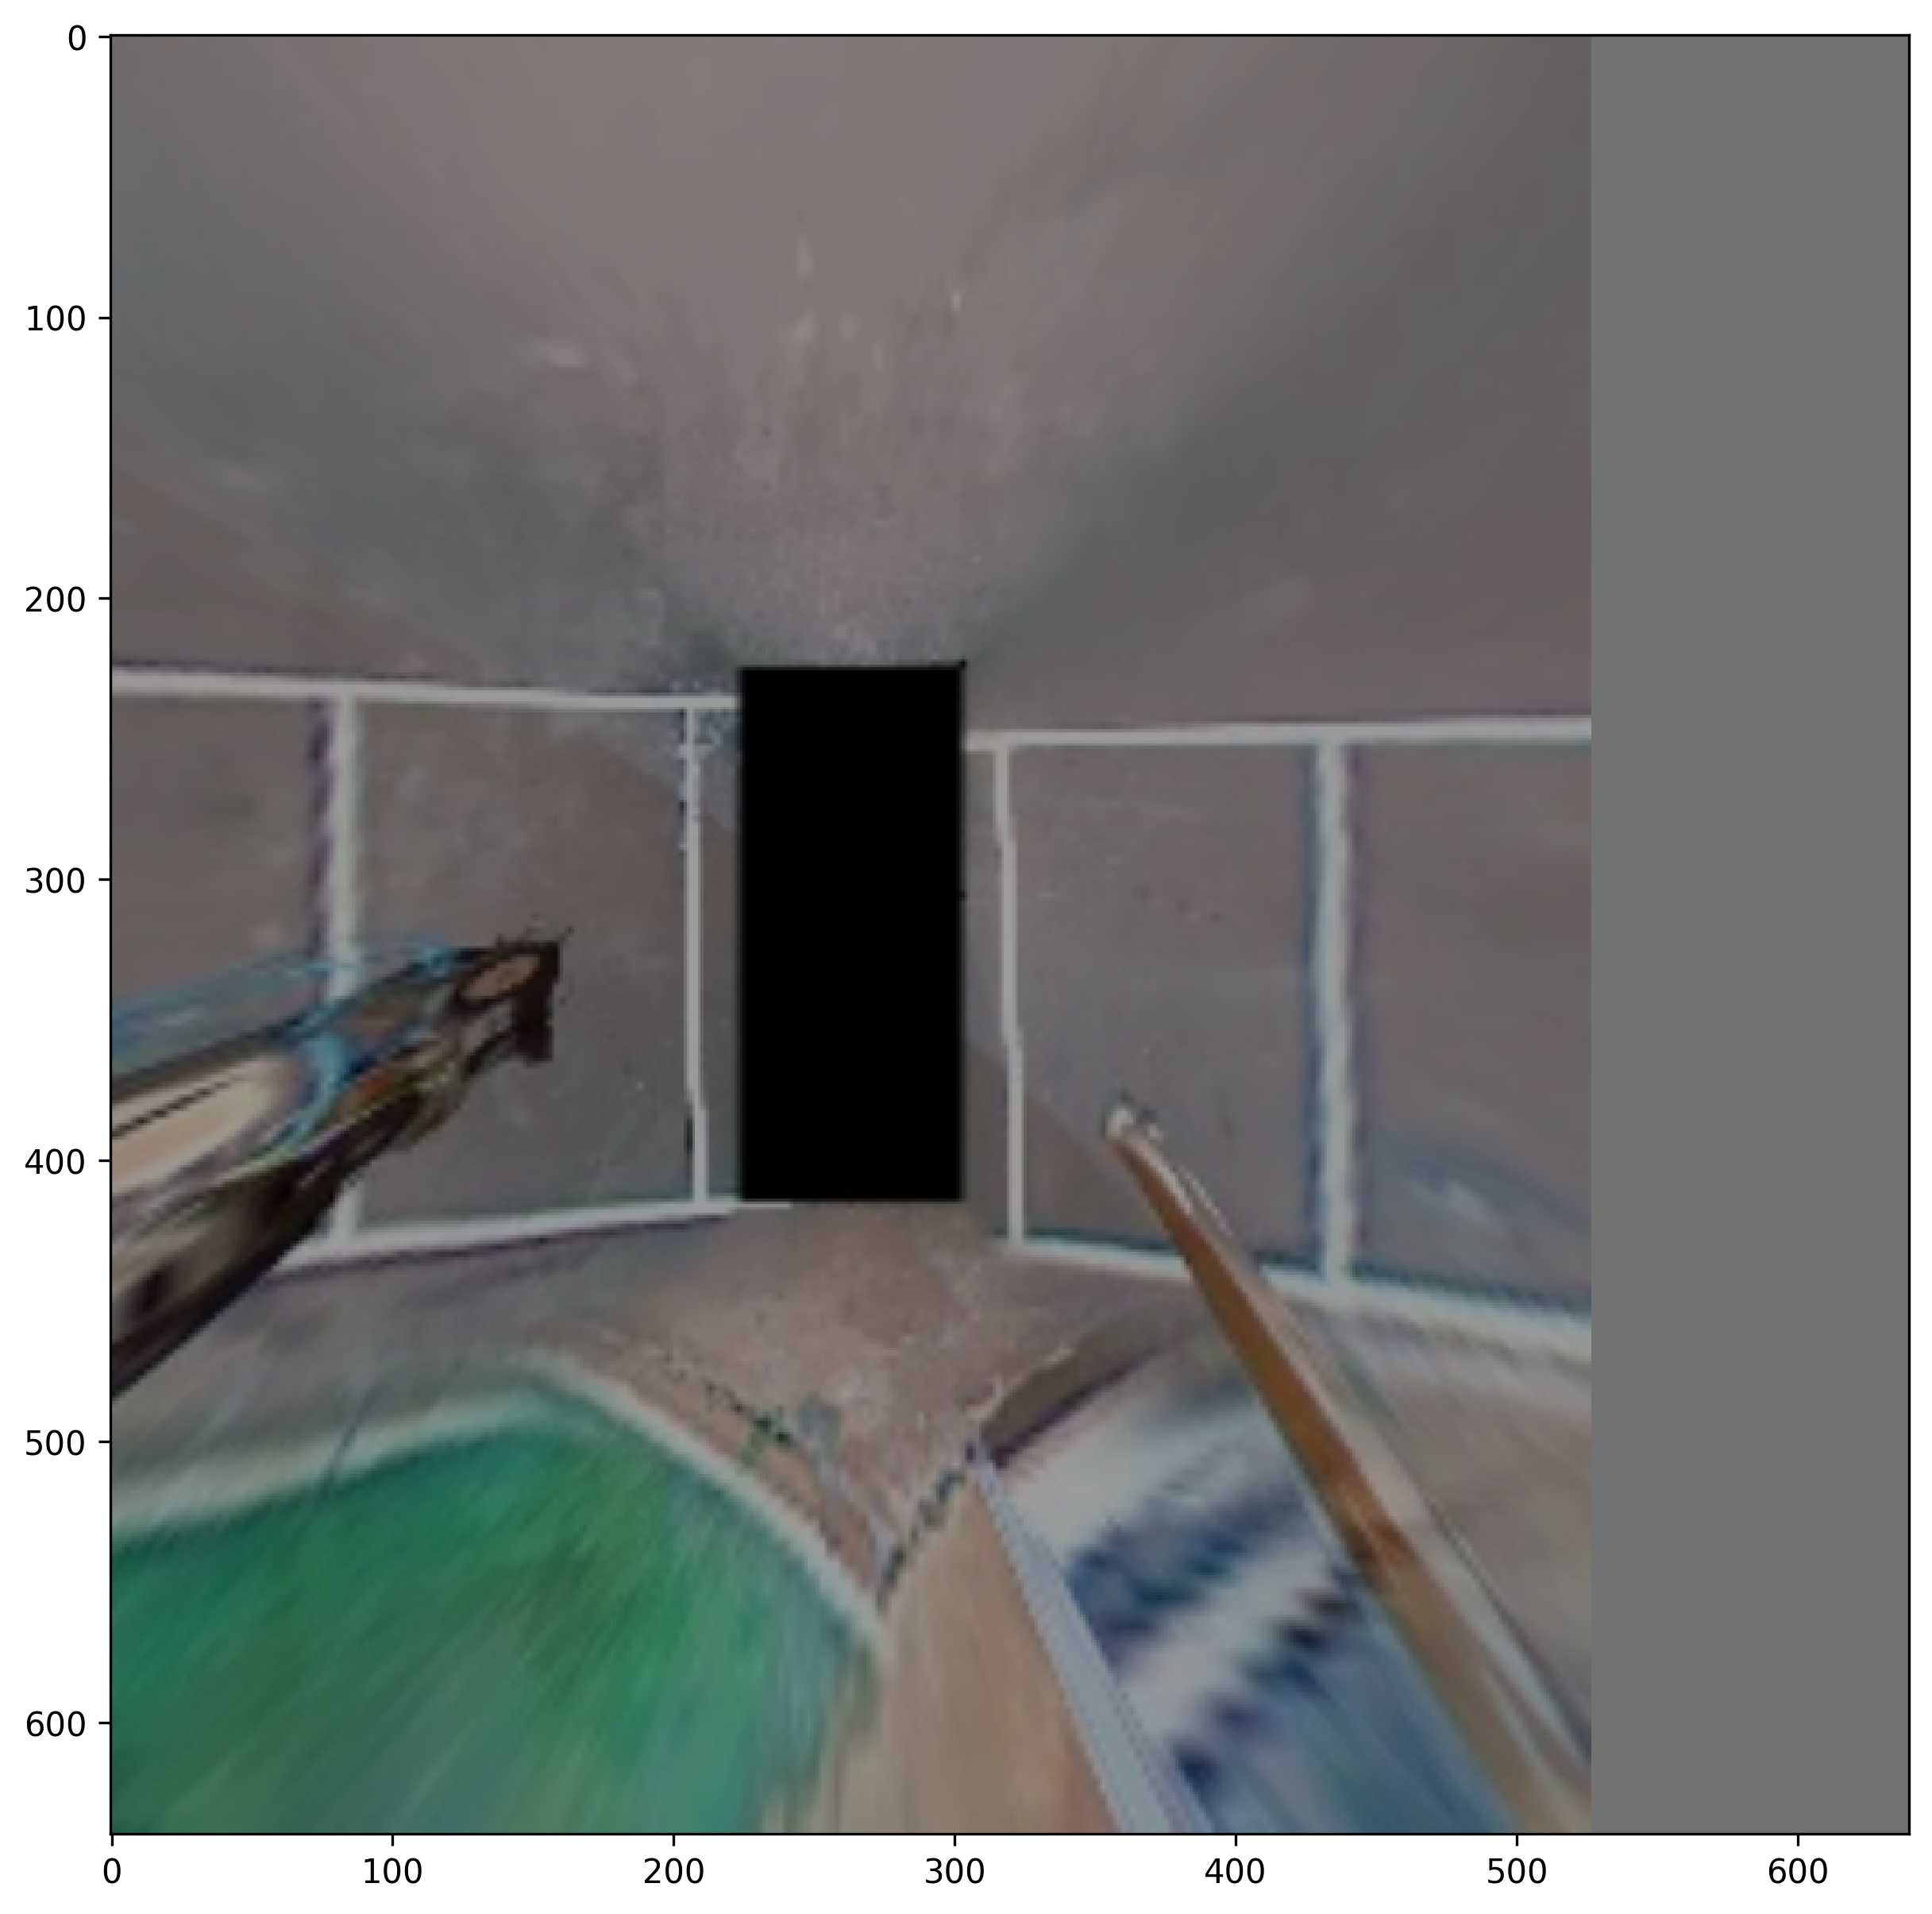

In [84]:
from avcv.visualize import *
item = dataset[0]
img = item[0]
# rgb_means = (123.675, 116.28, 103.53)
# std = (0.229, 0.224, 0.225)
rgb_img = tensor2imgs(img, mode='chw', to_rgb=False)
show(rgb_img)

In [21]:
train_loader = exp.get_data_loader(
            batch_size=args.batch_size,
            is_distributed=False,
            no_aug=True, dataset=dataset)

In [24]:
%debug

> /gitprojects/YOLOX/yolox/data/datasets/coco.py(105)pull_item()
    103 
    104         img = cv2.imread(img_file)
--> 105         assert img is not None
    106 
    107         return img, res.copy(), img_info, np.array([id_])

ipdb> img_file
'/data/compressed_ford_demo/train2017/20210703_stitched_image_000472.jpg'
ipdb> q


In [27]:
# inp[4]

# Samples

In [28]:
from yolox.data import DataPrefetcher
prefetcher = DataPrefetcher(train_loader)

In [29]:
inps, targets = prefetcher.next()

In [47]:
rgb_means, std

((123.675, 116.28, 103.53), (58.395, 57.120000000000005, 57.375))

(2, 2)


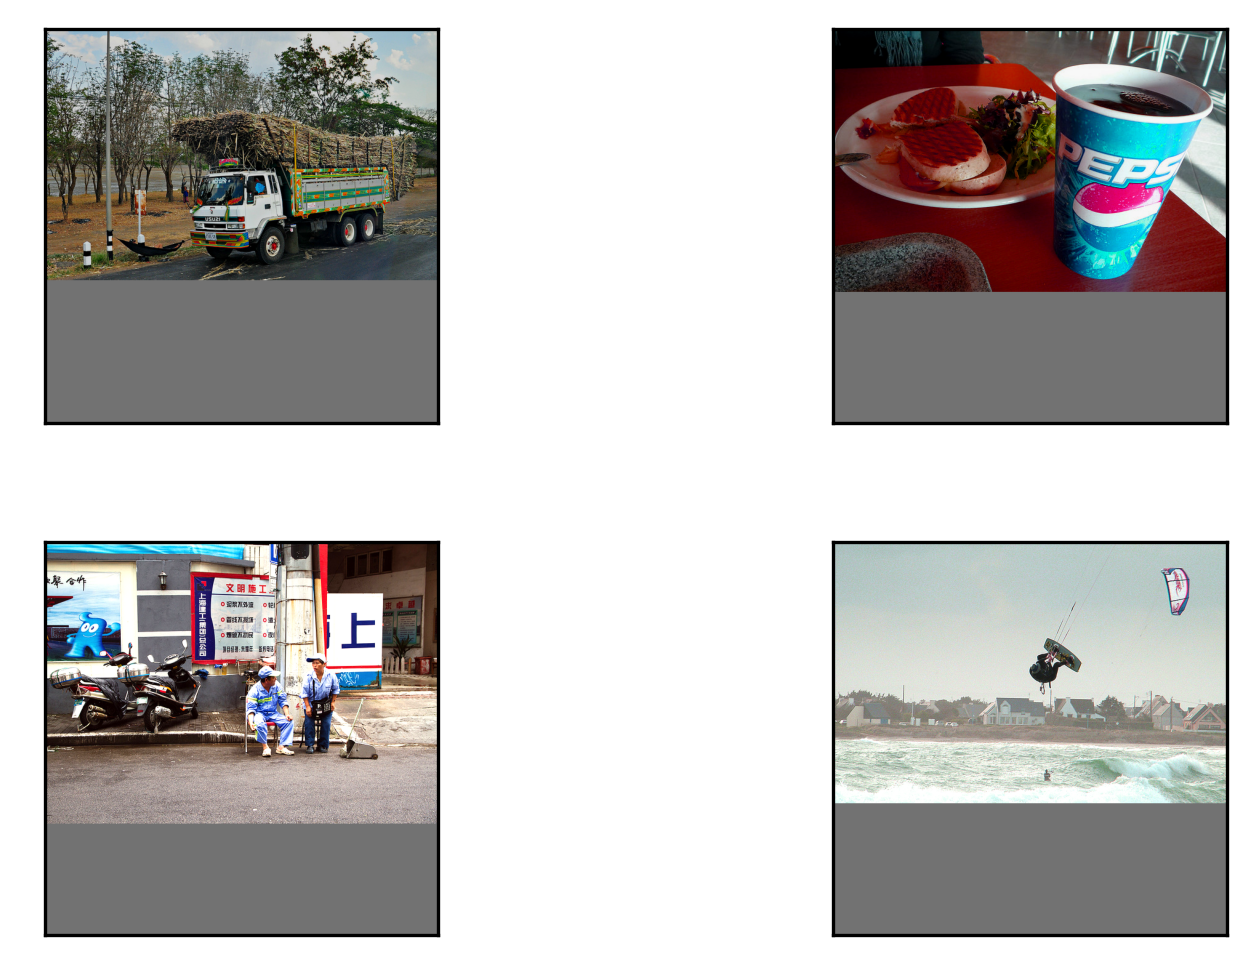

In [31]:
from avcv.visualize import show, plot_images
plot_images(out)

# Forward

In [33]:
outs = model(inps, targets)

In [35]:
# outs